In [1]:
import tensorflow
import csv
import itertools
import operator
import numpy as np
import nltk
import sys
import os
import time
import random
import tensorflow as tf
from tensorflow import keras
#from TurkishStemmer import TurkishStemmer
import pandas as pd
import re
nltk.download('punkt')


[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

In [2]:
# stemmer=TurkishStemmer.TurkishStemmer()

sentence_padding_token = "<PAD>"
sentence_start_token = "<START>"
sentence_unknown_token = "<UNK>"
sentence_unused_token="<UNUSED>"

data = pd.read_csv("processed_data.csv",header=None)

sentences=[]
labels=[]
num_rows = 0

for row in data.iterrows():

    sentence = row[1][0]
    label = row[1][1]
    sentence = re.sub('[:.(),;@$%^&*]', '', sentence)
    
    if (label != 3):
        num_rows+=1
    
    if label==1 or label==2:
        sentences.append(sentence)
        labels.append(0)

    elif label==4 or label==5:
        sentences.append(sentence)
        labels.append(1)

print("read " + str(num_rows) +" rows")

division_factor = len(sentences) * 50 // 100
print(division_factor)
print(len(sentences))

read 25800 rows
12900
25800


In [3]:
# --------------------------------------------------------------------
# tokenizing ---------------------------------------------------------
# --------------------------------------------------------------------
print("Tokenizing...")
tokenized_sentences = [nltk.word_tokenize(sent) for sent in sentences]
print("Done.")

Tokenizing...
Done.


In [4]:
#---------------------------------------------------------------------
# building a dictionary ----------------------------------------------
# --------------------------------------------------------------------
print("Building dictionary...")
vocabulary_size = 30000

# Count the word frequencies
word_freq = nltk.FreqDist(itertools.chain(*tokenized_sentences))
print("Found %d unique words tokens." % len(word_freq.items()))
 
# Get the most common words and build index_to_word and word_to_index vectors limited by vocabulary_size
vocab = word_freq.most_common(vocabulary_size-1)
print("vocab size is = " + str(len(vocab)))
index_to_word = [x[0] for x in vocab]

# inserting tokens <PAD>, <START>, <UNK>, <UNUSED>
index_to_word.insert(0,sentence_unused_token)
index_to_word.insert(0,sentence_unknown_token)
index_to_word.insert(0,sentence_start_token)
index_to_word.insert(0,sentence_padding_token)


# bulding a word to index dictionary
word_to_index = dict([(w,i) for i,w in enumerate(index_to_word)])
vocabulary_size += 4
print("Using vocabulary size %d." % vocabulary_size)


# ---------------------------------------------------------------------------------------
# adding start token to each sentence. Required for keras -------------------------------
# ---------------------------------------------------------------------------------------
for sent in tokenized_sentences: 
    sent.insert(0,sentence_start_token)
    

# ---------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------
for i, sent in enumerate(tokenized_sentences):
    tokenized_sentences[i] = [w if w in word_to_index else sentence_unknown_token for w in sent]

print("Tokenized sentence example %s" %tokenized_sentences[0])

Building dictionary...
Found 80785 unique words tokens.
vocab size is = 29999
Using vocabulary size 30004.
Tokenized sentence example ['<START>', '3', 'yıldır', 'tık', 'demedi']


In [5]:
# ---------------------------------------------------------------------------------------
# Create the training data --------------------------------------------------------------
# ---------------------------------------------------------------------------------------
print("Creating datasets...")

# converting to indices
X_temp = np.asarray([[word_to_index[w] for w in sent] for sent in tokenized_sentences])

# shuffling data
unison_data = list(zip(X_temp,labels))
random.shuffle(unison_data)
data, lbls = zip(*unison_data)    

# Splitting data
X_train, X_test = np.asarray(data[ : division_factor]), np.asarray(data[division_factor : ]) # 50, 50
Y_train ,Y_test = np.asarray(lbls[ : division_factor]), np.asarray(lbls[division_factor : ]) # 50, 50

# Sanity checks
print("\ncheck shapes ----------")
print("shape of X_train " + str(X_train.shape))
print("shape of X_test " + str(X_test.shape))
print("shape of Y_train " + str(Y_train.shape))
print("shape of Y_test " + str(Y_test.shape))
print("Done.")

Creating datasets...

check shapes ----------
shape of X_train (12900,)
shape of X_test (12900,)
shape of Y_train (12900,)
shape of Y_test (12900,)
Done.


In [6]:
# preparing input tensors
train_data = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=256) 

test_data = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256) 

# validtion set -------------------------
division_factor = len(test_data)*50//100 # 50 percent of the test_data = 25 percent of the total data

partial_x_train = train_data # to fit the model = 50 percent of the data
x_val = test_data[:division_factor] # to validate

partial_y_train = Y_train # to fit the model = 50 percent of the data
y_val = Y_test[:division_factor] # to validate

test_data = test_data[division_factor: ]
Y_test = Y_test[division_factor: ]

# Sanity checks
print("Training data length = %d Testing data length = %d" % (len(train_data), len(test_data)))
print("\ncheck shapes -----------")
print("shape of train_data " + str(train_data.shape) + " | must be -> (Training data length, maxlen)")
print("shape of train_data[0] " + str(train_data[0].shape) + " | must be -> (maxlen, )" ) 

print("shape of test " + str(test_data.shape) + " | must be -> (Testing data length, maxlen)")
print("shape of test[0] " + str(test_data[0].shape) + " | must be -> (maxlen, )" ) 

print("\ncheck shapes -----------")
print("train_data length %d" %len(train_data))
print("shape of partial_x_train " + str(partial_x_train.shape))
print("shape of partial_x_train[0] " + str(partial_x_train[0].shape)  ) 
print("shape of x_val "+ str(x_val.shape))
print("\nshape of partial_y_train "+str(partial_y_train.shape))
print("shape of partial_y_train[0] "+str(partial_y_train[0].shape))
print("shape of y_val "+str(y_val.shape))

# building model
model = keras.Sequential()
model.add(keras.layers.Embedding(vocabulary_size, 32))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(32, activation=tf.nn.relu))
model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))

model.summary()

#model=keras.Sequential()
#model.add(keras.layers.Embedding(vocabulary_size,output_dim=32))
#model.add(keras.layers.LSTM(32))
#model.add(keras.layers.Dense(1, activation='sigmoid'))
print(model.summary())


model.compile(optimizer=tf.train.AdamOptimizer(),
              loss='binary_crossentropy',
              metrics=['accuracy'])



Training data length = 12900 Testing data length = 6450

check shapes -----------
shape of train_data (12900, 256) | must be -> (Training data length, maxlen)
shape of train_data[0] (256,) | must be -> (maxlen, )
shape of test (6450, 256) | must be -> (Testing data length, maxlen)
shape of test[0] (256,) | must be -> (maxlen, )

check shapes -----------
train_data length 12900
shape of partial_x_train (12900, 256)
shape of partial_x_train[0] (256,)
shape of x_val (6450, 256)

shape of partial_y_train (12900,)
shape of partial_y_train[0] ()
shape of y_val (6450,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          960128    
_________________________________________________________________
global_average_pooling1d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None,

In [7]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=15,
                    batch_size=32, 
                    validation_data=(x_val, y_val),
                    verbose=1)


Train on 12900 samples, validate on 6450 samples
Epoch 1/15
12900/12900 [==============================] - 7s 514us/step - loss: 0.6926 - acc: 0.5228 - val_loss: 0.6890 - val_acc: 0.7157
Epoch 2/15
12900/12900 [==============================] - 5s 357us/step - loss: 0.6843 - acc: 0.6040 - val_loss: 0.6770 - val_acc: 0.6381
Epoch 3/15
12900/12900 [==============================] - 5s 367us/step - loss: 0.6456 - acc: 0.7012 - val_loss: 0.6023 - val_acc: 0.7093
Epoch 4/15
12900/12900 [==============================] - 5s 384us/step - loss: 0.4985 - acc: 0.8402 - val_loss: 0.4379 - val_acc: 0.8436
Epoch 5/15
12900/12900 [==============================] - 5s 406us/step - loss: 0.3549 - acc: 0.8874 - val_loss: 0.3683 - val_acc: 0.8544
Epoch 6/15
12900/12900 [==============================] - 5s 403us/step - loss: 0.2864 - acc: 0.9056 - val_loss: 0.3283 - val_acc: 0.8623
Epoch 7/15
12900/12900 [==============================] - 5s 381us/step - loss: 0.2464 - acc: 0.9183 - val_loss: 0.3072 - v

In [8]:
results = model.evaluate(test_data, Y_test)

print(results)

6450/6450 [==============================] - 0s 36us/step
[0.2846570395868878, 0.896124031026234]


In [9]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'val_loss', 'val_acc', 'acc'])

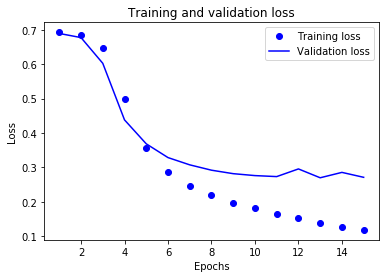

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

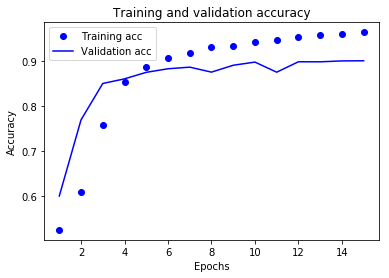

In [11]:
plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [11]:
from sklearn.metrics import confusion_matrix
import itertools

y_pred = model.predict(test_data)
y_true = Y_test

print("sanity check")
print("{} inctences predicted".format(len(y_pred)))
print("{} inctences Exist".format(len(y_true)))

cm = confusion_matrix(y_true, y_pred.round())  #round

sanity check
6450 inctences predicted
6450 inctences Exist


In [12]:
def plot_confusion_matrix(cm, classes, 
                          normalize=False,
                         title="Confusion matrix",
                         cmap = plt.cm.Blues):
    plt.imshow(cm,interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm=cm.astype('float')/ cm.sum(axis=1)[:,np.newaxis]
        print("normalized Confusion Matrix")
    else:
        print("Confusion matrix without normalization")
    
    print(cm)
    
    thresh=cm.max()/2.
    
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i,j],
                horizontalalignment='center',
                color='white' if cm[i,j]>thresh else 'black')
    plt.tight_layout()
    plt.ylabel("True values")
    plt.xlabel("predicted values")
    

Confusion matrix without normalization
[[2804  386]
 [ 284 2976]]


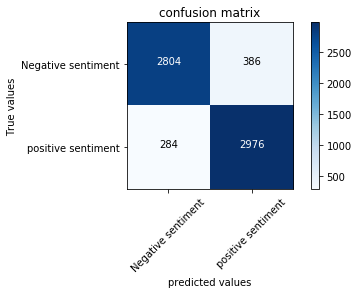

In [13]:
cm_plot_labels=['Negative sentiment','positive sentiment']
plot_confusion_matrix(cm,cm_plot_labels,title='confusion matrix')